In [2]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
from scipy.optimize import leastsq, least_squares
import utils
from collections import defaultdict
from LinearAlignment import LinearAlignment

In [3]:
np.random.seed(50)
coord_cols = ['x', 'y', 'z']
speed_cols = ['Vx', 'Vy', 'Vz']
state_cols = coord_cols + speed_cols
# anchor_cols = state_cols + ['distance', 'abs_speed']

In [4]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [163]:
# data.to_csv('transformed_data.csv')

In [5]:
data = pd.read_csv('transformed_data.csv', index_col = 'id')
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
3400,1.390544e+18,1,-16092.302493,-13275.413883,7590.794788,4.006022,-0.632871,0.755590,-15968.168631,-13270.526776,7476.190362,4.060799,-0.675317,0.756349
3401,1.390545e+18,1,-10514.368549,-13620.712878,8282.998531,4.769115,0.152157,0.291364,-10496.083783,-13639.341658,8146.091533,4.843105,0.083388,0.303908
3402,1.390546e+18,1,-3986.926577,-12670.717346,8183.491284,5.458695,1.457726,-0.528862,-3145.280631,-13191.900341,8233.661369,6.138835,1.558699,-0.598268
3403,1.390548e+18,1,3100.751237,-9519.306227,6650.863355,5.455100,3.683694,-2.025330,4435.593634,-9254.477851,6315.682653,5.560928,4.483516,-2.501181
3404,1.390549e+18,1,8687.726999,-3020.484451,2743.930491,2.619850,6.381215,-4.073094,8755.212612,-2677.589919,2512.017527,2.467354,6.488102,-4.129147


In [98]:
np.random.seed(50)  
sat_id = 372    
    
sat_data = data[data.sat_id == sat_id ]
sat_data['t'] = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch']).iloc[0]) /
                       np.timedelta64(1, 'D')).astype(float)

n_train = len(sat_data[~pd.isna(sat_data.x)])

pred = pd.DataFrame(index = sat_data.iloc[n_train:].index)
pred['epoch'] = sat_data['epoch'].iloc[n_train:].values
pred['t'] = sat_data['t'].iloc[n_train:].values
pred['sat_id'] = sat_id



for feature_name in state_cols:

    q = InterpolatedUnivariateSpline(sat_data['t'][:n_train], sat_data[f'{feature_name}_sim'][:n_train]).roots()
    T = (q[-1]-q[-3])
    print(T)

    # create a DataFrame for prophet model()
    ts = pd.DataFrame([])
    ts['ds'] = pd.to_datetime(sat_data ['epoch']).values
    ts['y'] =sat_data [f'{feature_name}_sim'].values


    # define the time frame for the first forecast 
    future =ts[n_train:] [['ds']]

    # define the model
    m = Prophet(changepoint_prior_scale = T/20,
    weekly_seasonality = False,
    yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=20)

    #fit the model and make the forecast
    m.fit(ts[:n_train])
    forecast = m.predict(future)

    pred[feature_name]  = forecast.loc[:, 'yhat'].values




C:\Users\Tatiana\Anaconda3\envs\idao\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.11714179322383167
0.1167305406132586
0.11649309523456441
0.11660152919367217
0.1170509325013569
0.11686925332796338


In [75]:
print(sum(q[0:-1:2]))
print(sum(q[1:-1:2]))
print((sum(q[1:-1:2])-sum(q[0:-1:2]))/len(q)*4)
print(T)

270.2556115172802
274.4843216268103
0.11828559746937298
0.11686925332796338


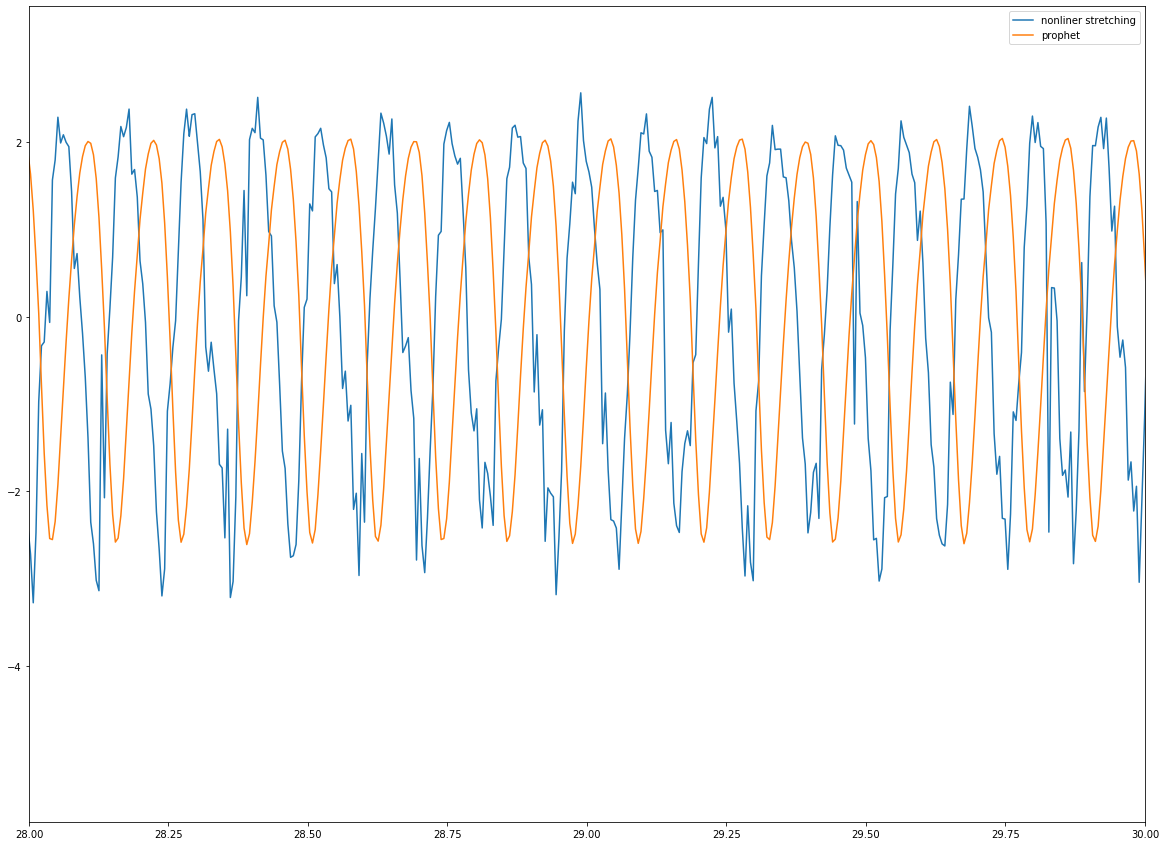

In [110]:
plt.figure(figsize = (20,15))

plt.plot(sat_data.t,sat_data.Vz_sim, label = 'nonliner stretching')
plt.plot(pred.t, pred.Vz, label = 'prophet')
plt.xlim([28,30])
plt.legend()